## 1. Imports

In [2]:
import tensorflow as tf
from PIL.Image import DecompressionBombError
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2
import praw,requests
import psaw
import datetime as dt
import os
import sys
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import random

## 2. Functions

In [25]:
#Checks if two images are identical, returns true if they are, returns true if a file is blank
def compare2images(original,duplicate):
    if original is None or duplicate is None:
        return True #delete emtpy pictures
    if original.shape == duplicate.shape:
        #print("The images have same size and channels")
        difference = cv2.subtract(original, duplicate)
        b, g, r = cv2.split(difference)
        if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
            return True
        else:
            return False
    else:
        return False

#A simple progress bar for transparency on the 20000 image processing tasks
def progress(purpose,currentcount, maxcount):
    sys.stdout.write('\r')
    sys.stdout.write("{}: {:.1f}%".format(purpose,(100/(maxcount-1)*currentcount)))
    sys.stdout.flush()

#custom image data generator following this example https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
def custom_file_image_generator(inputPath,bs,mode="train",aug=None, max = 1, frompath="picsnew"):
    f = open(inputPath, "r")
    while True:
        images = []
        labels = []
        while len(images)<bs:
            line = f.readline()
            if line == "":
                f.seek(0)
                line = f.readline()
                # if we are evaluating we should now break from our
                # loop to ensure we don't continue to fill up the
                # batch from samples at the beginning of the file
                if mode == "eval":
                    break
            label = int(line.split(".")[0].split("_")[0])
            stripped = line.strip('\n')
            image = plt.imread(f"{frompath}{stripped}")
            #Removes alpha channel
            image = np.float32(image)[:,:,:3]
            #Neceesary resizing to avoid PIL pixel cap
            while image.shape[0] * image.shape[1]>89478485:
                image = cv2.resize(image, (0,0), fx=0.5, fy=0.5)
            cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
            images.append(image)
            labels.append(label/max)
        labels = np.asarray(labels).T
        yield(np.asarray(images),labels)

## 3. Set up Reddit api for downloading images

In [4]:
#Set up API keys from .gitignored file
with open('config.json') as config_file:
    config = json.load(config_file)['keys']

# Sign into Reddit using API Key
reddit = praw.Reddit(user_agent="Downloading images from r/art for a machine learning project",
                     client_id=config['client_id'],
                     client_secret=config['client_secret'],
                     username=config['username'],
                     password=config['password'])

## 4. Downloading pictures from Reddit r/art using PSAW and PRAW

In [ ]:
#187mb for 200 pics, approx 18.7gb for 20000
#Time periods to choose to download from
Jan12018 = int(dt.datetime(2018,1,1).timestamp())
Jan12019 = int(dt.datetime(2019,1,1).timestamp())
Jan12020 = int(dt.datetime(2020,1,1).timestamp())
Jan12021 = int(dt.datetime(2021,1,1).timestamp())

#Pass a PRAW instance into PSAW so that scores are available
api = psaw.PushshiftAPI(reddit)
#Number of posts to try and download
n = 30000
#Path to download to
dlpath = "pics2/"

print("Looking for posts using Pushshift...")
#this step takes a while
posts = list(api.search_submissions(after = Jan12019, before=Jan12020, subreddit='art', limit = n*10))
numpostsfound = len(posts)
print(f"Number of posts found:  {numpostsfound}")
counter = 0

for post in posts:
    if post.score>1:
        progress("Downloading",counter,numpostsfound)
        counter +=1
        url = (post.url)
        #Save score for ML training, and post id for unique file names
        file_name = str(post.score) + "_" + str(post.id) + ".jpg"
        try:
            #use requests to get image
            r = requests.get(url)
            fullfilename = dlpath + file_name
            #save image
            with open(fullfilename,"wb") as f:
                f.write(r.content)
        except (
            requests.ConnectionError,
            requests.exceptions.ReadTimeout,
            requests.exceptions.Timeout,
            requests.exceptions.ConnectTimeout,
        ) as e:
            print(e)
            
files = [f for f in os.listdir(dlpath) if os.path.isfile(os.path.join(dlpath, f))]
#Number of files downloaded not always the same as requested due to connection errors
print(f'\nNumber of files downloaded: {len(files)}')

## 5. Processing code that removes pictures that are deleted/corrupt
Might need to run multiple times if low on ram

In [7]:
#Path to delete bad pictures from
path = "pics2/"

files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
cull = []
counter = 0
length = len(files)
print(f"Original Number of files: {length}")
#Template of a bad picture
deletedtemplate = cv2.imread("exampledeleted.jpg")
deletedtemplate2 = cv2.imread("exampledeleted2.jpg")
for file in files:
    progress("Deleting bad files",counter,length)
    counter+=1
    fullfilename = path + file
    candidate = cv2.imread(fullfilename)
    #if it's the same picture as the template or the picture is None
    if compare2images(deletedtemplate,candidate) or compare2images(deletedtemplate2,candidate):
        #delete
        os.remove(fullfilename)
files2 = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
print(f"\nFinal Number of files: {len(files2)}")

Original Number of files: 11377
Deleting bad files: 100.0%
Final Number of files: 11364


## 6. Preprocessing code that corrects grayscale images to RGB and rescales pictures to have maximum width or height of 1000
If I ran nn training with large images, it would take too long, and if I ran on google colab,
I wouldn't have the drive space for all the pictrues

In [ ]:
#Path being read from
path = 'pics2/'
#Path writing to
path2 = 'picsfix/'
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
length = len(files)
counter = 0
failures = []
for file in files:
    try:
        progress("Resizing and fixing pictures",counter,length)
        #OpenCV doesn't open jpegs
        img = plt.imread(f'{path}{file}')
        if len(img.shape) <3:
            # print(file)
            # print(img.shape)
            img= cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            #Resize to 1000 max
        largestdim = max(img.shape)
        targetlargestdim = 1000
        scaling= targetlargestdim / largestdim
        #print(scaling)
        if(scaling<1): #If image is already smaller, don't bother upscaling
            smaller = cv2.resize(img, (0,0), fx=scaling, fy=scaling)
        else:
            smaller = img
        filename = path2+file
        plt.imsave(filename,smaller)
        counter += 1
    except DecompressionBombError as e:
        print(file)
        print("Decomp error")
print("\ndone")

## 7. Plot histogram of scores to see how bad the bias towards lower scores is

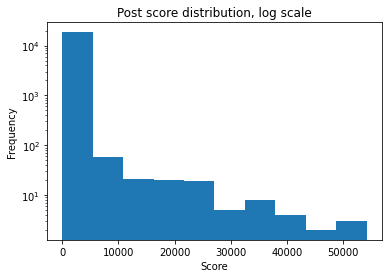

In [11]:
path = "picsfix2"
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
numpics = len(files)
labelsall = []
for file in files:
    labelsall.append(int(file.split(".")[0].split("_")[0]))
#print(labelsall)
plt.hist(labelsall)
plt.yscale("log")
plt.ylabel("Frequency")
plt.xlabel("Score")
plt.title("Post score distribution, log scale")
plt.show()

## 7. Split files into training and testing sets and write the names of files to txt files
I'm following [this guide](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/)
and using a file reader to reset the index to 0 seemed like the easiest solution to mimic what the author set up.

In [12]:
#Path of pictures to split and write txts for
path = "picsfix2/"
trainingpath = "training.txt"
testingpath = "testing.txt"
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
#randomize to avoid passing pictures to the neural net in alphabetical order
random.shuffle(files)
#print(files)
trainindex = int(np.round(0.8 * len(files)))
training = files[0:trainindex]
testing = files[trainindex:]
with open(trainingpath, 'w') as f:
    for item in training:
        f.write("%s\n" % item)
with open(testingpath, 'w') as f:
    for item in testing:
        f.write("%s\n" % item)

## 8. Actual neural net training using Convolutional Neural Net
I didn't have enough ram to train locally, so I ended porting to Google Colab and training there.
The trainin has not been succesful so far, and I haven't taken the time to diagnose why yet.

In [ ]:
#Path of preprocessed pictures
path = "picsfix2/"
#Paths of training and testing txts that have file names
trainPath = 'training.txt'
testpath = 'testing.txt'
#Get all file names
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
numpics = len(files)
labelsall = []
for file in files:
    labelsall.append(int(file.split(".")[0].split("_")[0]))
highestScore = max(labelsall)
print(f'Highest score: {highestScore}')


#Store all image arrays and image names in a list
input_shape=(None, None,3)

NUM_EPOCHS = 12
BS = 1
NUM_TRAIN_IMAGES = int(np.round(0.8 * len(files)))
NUM_TEST_IMAGES = len(files)-NUM_TRAIN_IMAGES
traingen = custom_file_image_generator(trainPath,BS, "train" , None,highestScore, path)
testgen = custom_file_image_generator(testpath,BS, "train", None,highestScore, path)
tf.keras.backend.clear_session()
conv_model = models.Sequential()
#normalize pictures to [0 1]
conv_model.add(layers.experimental.preprocessing.Rescaling(1./255))
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=input_shape))
conv_model.add(layers.GlobalMaxPooling2D())
# conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
conv_model.add(layers.Flatten())
#conv_model.add(layers.Dropout(0.2))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(1, activation='linear'))
LEARNING_RATE = 1e-4
conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])
history_conv = conv_model.fit(traingen,
                                steps_per_epoch= NUM_TRAIN_IMAGES // BS,
                                validation_data=testgen,
                                validation_steps = NUM_TEST_IMAGES // BS,
                              epochs=NUM_EPOCHS)
modelfilename = 'art2.h5'
conv_model.save(modelfilename)
# plt.plot(history_conv.history['loss'])
# plt.plot(history_conv.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train loss', 'val loss'], loc='upper right')
# plt.show()
#
#
# plt.plot(history_conv.history['acc'])
# plt.plot(history_conv.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy (%)')
# plt.xlabel('epoch')
# plt.legend(['train accuracy', 'val accuracy'], loc='lower right')
# plt.show()


Highest score: 54157
Epoch 1/12
 1443/14918 [=>............................] - ETA: 1:37:21 - loss: 0.0014 - acc: 0.0049